In [6]:
from HeaderP import *
from __future__ import print_function
import numpy as np
import os
import scipy.io
import os.path as path
import pylab
import matplotlib
import struct
import time
import h5py
#import loaders
import sys
#from const import *
from math import *

In [106]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.plot([0,15], [np.percentile(feh_sing[m2],95),np.percentile(feh_sing[m2],95)],'b-')
            plt.plot([0,15], [np.percentile(feh_sing[m2],5),np.percentile(feh_sing[m2],5)],'b-')
            plt.plot([np.percentile(r_sing[m2],95),np.percentile(r_sing[m2],95)], [-3,0.5],'b-')
            plt.plot([np.percentile(r_sing[m2],5),np.percentile(r_sing[m2],5)], [-3,0.5],'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

In [8]:
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        fehmin = np.percentile(feh_sing[m2],5)
        fehmax = np.percentile(feh_sing[m2],95)
        
        #fehmin = min(feh_sing[m2])
        #fehmax = max(feh_sing[m2])
        #fehscatter[i] = fehmax-fehmin
        
        #fehscatter[i] = np.std(feh_sing[m2])
        #fehmin = np.mean(feh_sing[m2])-fehscatter[i]
        #fehmax = np.mean(feh_sing[m2])+fehscatter[i]

        
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmax, 'b-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmin, 'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            
            
            
            
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


"""def monoage_line_range_med(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        
        r_sing, feh_sing = r_sing[m2], feh_sing[m2]
        
        mov_r, mov_feh = movingMed_time(r_sing, feh_sing, 0.1, 0.5) 
        movint = interp1d(mov_r, mov_feh)
        
        m2 = (r_sing>min(mov_r))&(r_sing<max(mov_r))
        
        m3 = (feh_sing[m2]>movint(r_sing[m2]))
        
        fehmin = np.percentile(feh_sing[m2][m3], 80)
        fehmax = np.percentile(feh_sing[m2][~m3], 20)
        fehscatter[i] = fehmax-fehmin
        #fehscatter[i] = np.std(feh_sing[m2])
        
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(mov_r, mov_feh, 'k-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmax, 'b-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmin, 'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            
            
            
            
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter"""



"def monoage_line_range_med(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],\n                feherr=[],checkplt=True):\n    colors = getcolor(range(len(agebin)+1))\n    slopes = np.zeros(len(agebin)-1)\n    fehscatter = np.zeros(len(agebin)-1)\n    \n    plt.figure(figsize=(20,8))\n    for i in trange(len(agebin)-1):\n        m = (age>agebin[i])&(age<agebin[i+1])\n        if sum(m)==0:\n            fehscatter[i] = np.nan\n            continue\n        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))\n        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)\n        \n        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])\n        if sum(m2)==0:\n            fehscatter[i] = np.nan\n            continue\n        \n        r_sing, feh_sing = r_sing[m2], feh_sing[m2]\n        \n        mov_r, mov_feh = movingMed_time(r_sing, feh_sing, 0.1, 0.5) \n        movint = interp1d(mov_r, mov_feh)\n        \n        m2 = (r_sing>min(mov_r))&(r_sing<ma

# MCM13

In [64]:
f1 = readfits('mcm13_output_zmax6.35.fits')
f1.columns

Index(['name', 'tb_ns', 'ri', 'vri', 'vzi', 'fe', 'o', 'mg', 'rf', 'phif',
       'zzf', 'vrf', 'vphif', 'vzf'],
      dtype='object')

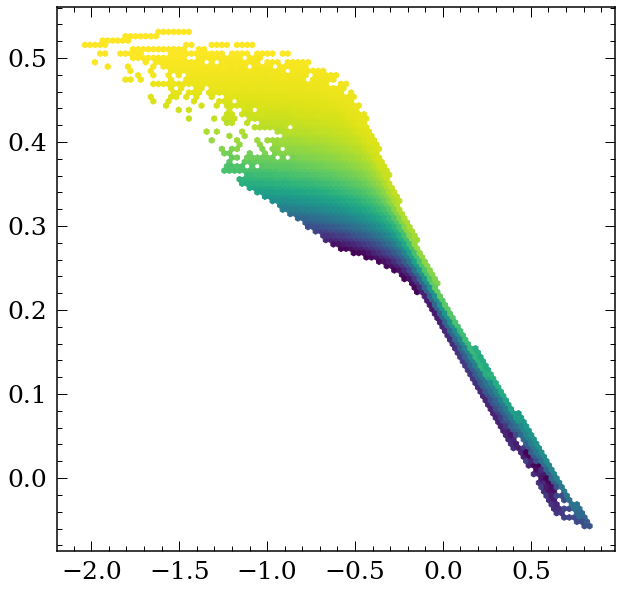

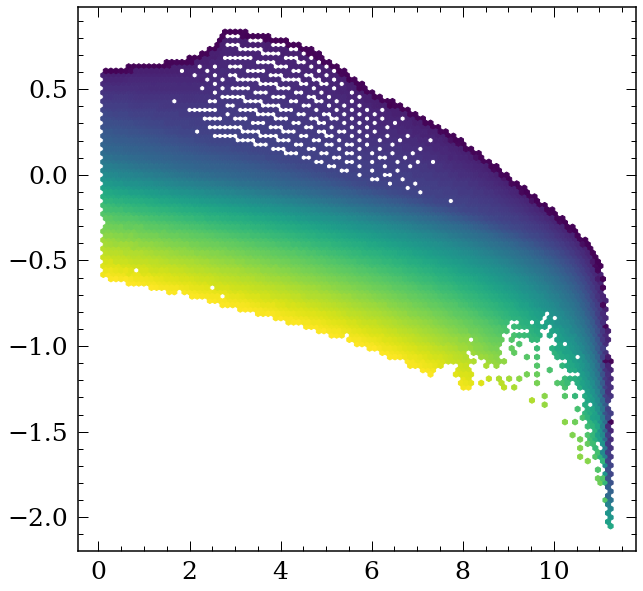

In [65]:
f1['feh'] = f1['fe']-7.53
f1['mgh'] = f1['mg']-7.45
f1['mgfe'] = f1['mgh']-f1['feh']
f1['age'] = 13.8-(f1['tb_ns']-2)
f1 = f1.loc[f1['feh']>-3].reset_index(drop=True)
f1['R'] = f1['rf']
f1['ri'] = f1['ri']/1.67

data = f1

plt.figure()
plt.hexbin(f1['feh'], f1['mgfe'], C = f1['age'])

plt.figure()
plt.hexbin(f1['age'], f1['feh'], C = f1['ri'])

100%|██████████| 14/14 [00:00<00:00, 73.17it/s]


0.0 1.9819010496139526
1.0 1.71239173412323
2.0 1.5692987442016602
3.0 1.177452564239502
4.0 1.2477203607559204
5.0 1.4451439380645752
6.0 1.5190123319625854
7.0 1.5718042850494385
8.0 1.7117847204208374
9.0 1.5943057537078857
10.0 1.2001432180404663
11.0 1.165776252746582
12.0 nan
13.0 nan


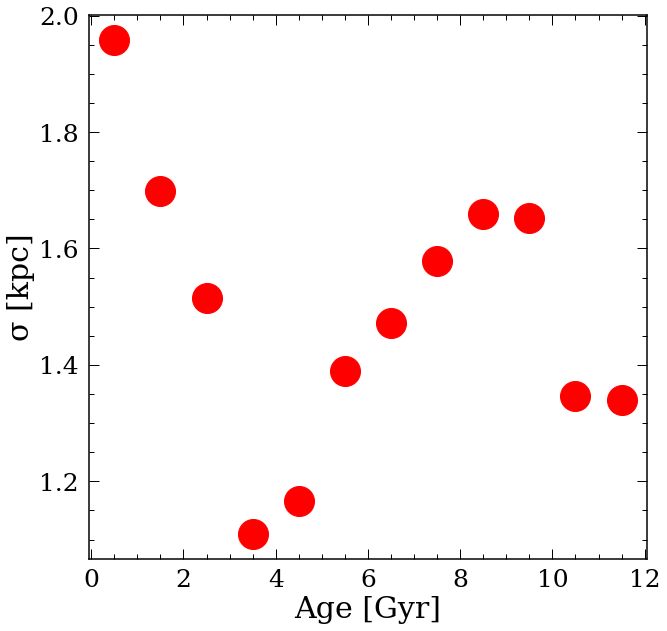

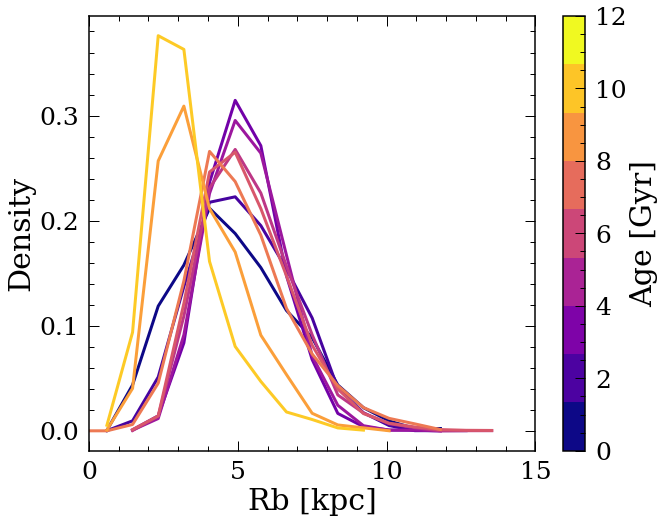

In [68]:
xlims = [7,10]
m = (data['R']>xlims[0])&(data['R']<xlims[1])
m = m&(abs(data['zzf'])<0.5)
#m = m&((data['ri']>xlims[0])&(data['ri']<xlims[1]))

agebin = np.linspace(0,14,15)
for i in trange(len(agebin)-1):
    m2 = (data[m]['age']>agebin[i])&(data[m]['age']<agebin[i+1])
    data_sing = data[m][m2].dropna()
    plt.plot(agebin[i]/2+agebin[i+1]/2,
             np.std(data_sing['R']-data_sing['ri']),'ro', markersize=30)
    print(agebin[i], np.std(data_sing['ri']))
plt.xlabel('Age [Gyr]')
plt.ylabel('σ [kpc]')


agebin_Rb = np.linspace(0,12,10)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
data_rbdis = data[m]
for i in range(len(agebin_Rb)-1):
    sub_sing = data_rbdis.loc[(data_rbdis['age']>agebin_Rb[i])&(data_rbdis['age']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['ri'], 
                            bins=np.linspace(-5,20,30), density=True)
    
    m2 = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m2]/2, fre[m2], color=agebin_colors[i], linewidth=3)
    
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.xlim([0,15])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')





100%|██████████| 14/14 [00:01<00:00,  9.58it/s]


<Figure size 1440x576 with 0 Axes>

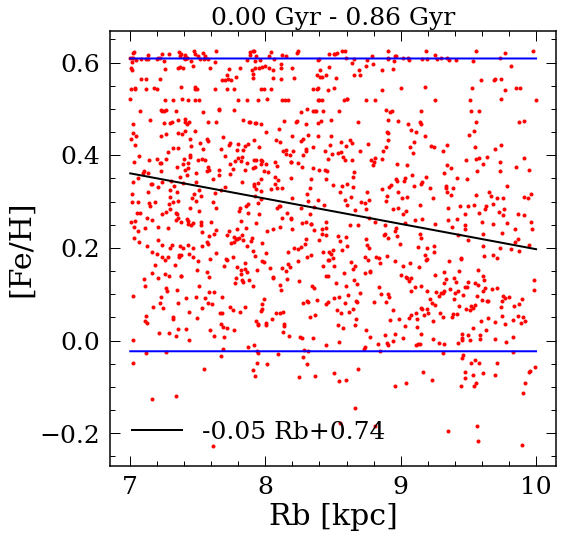

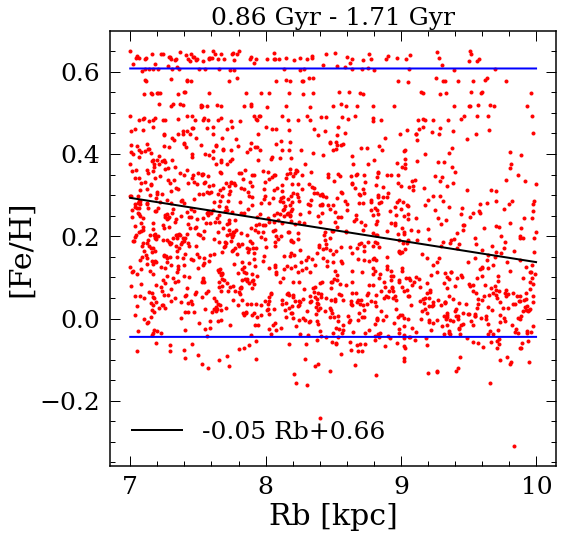

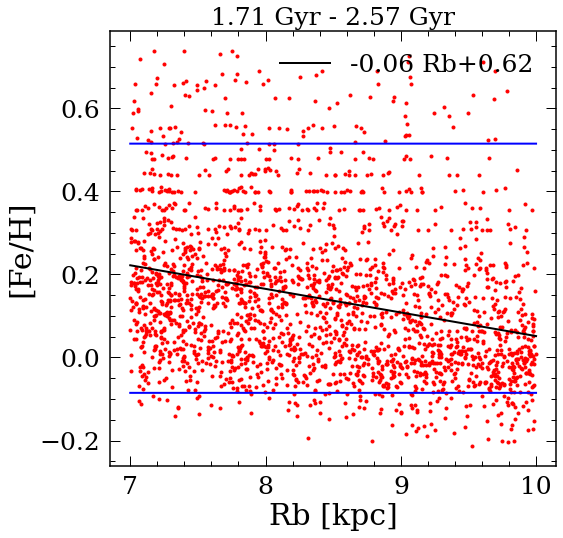

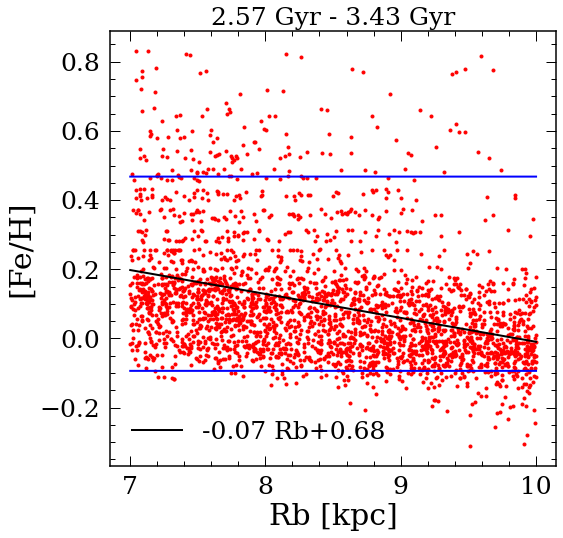

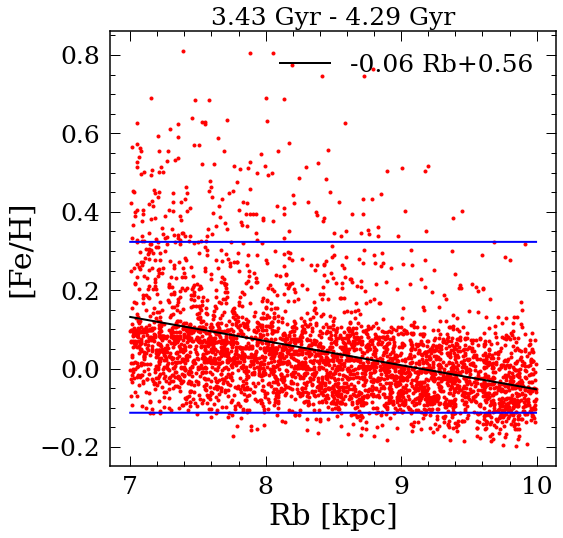

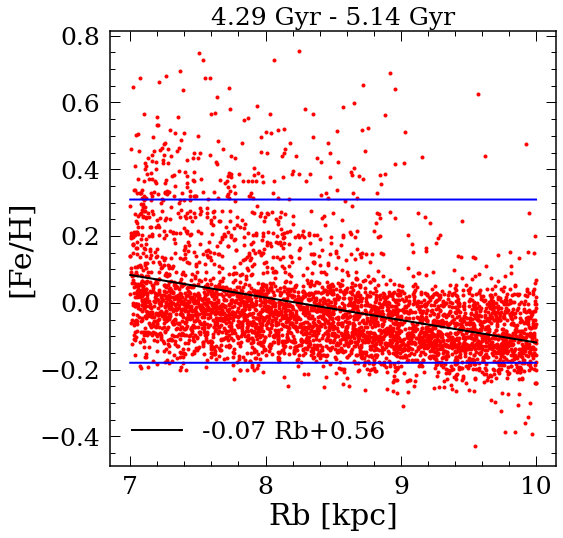

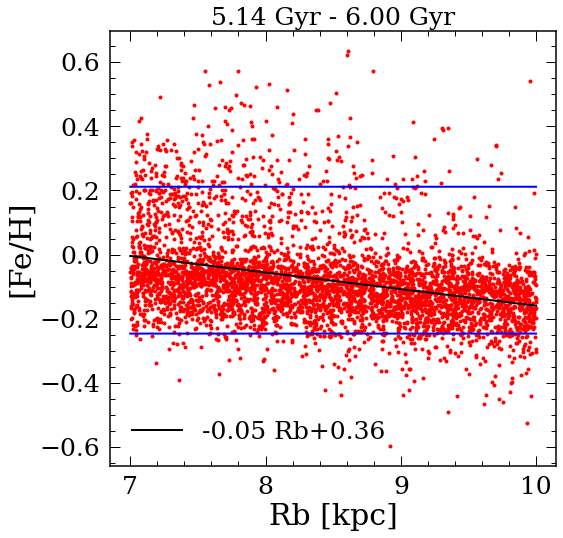

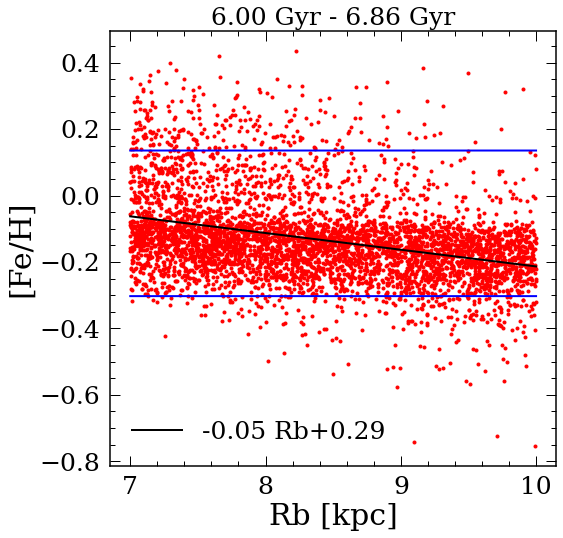

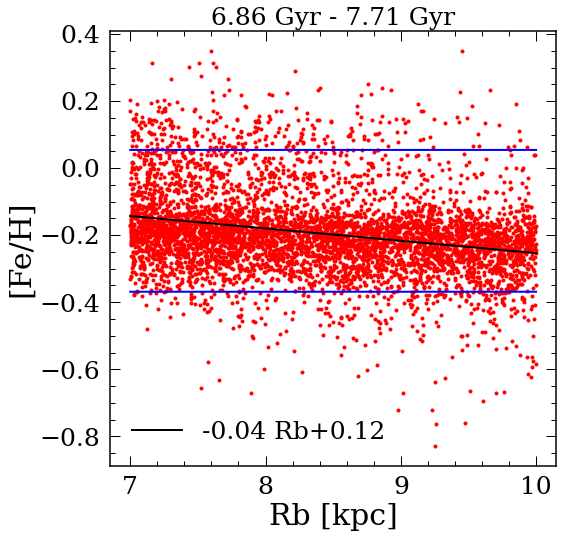

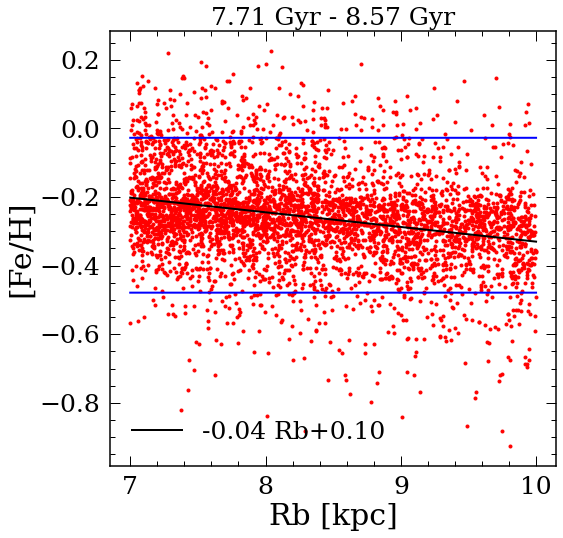

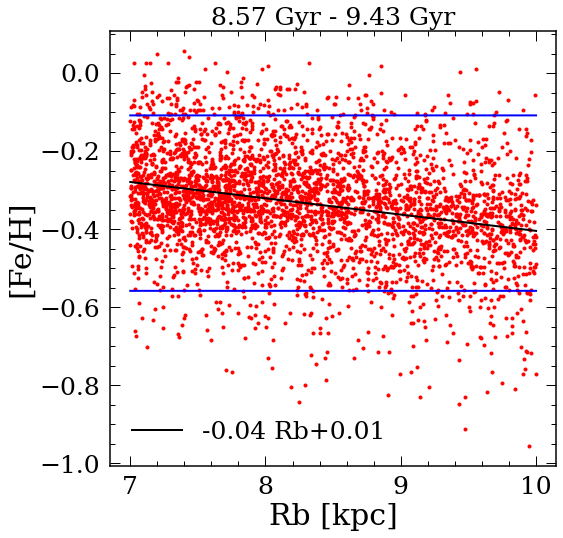

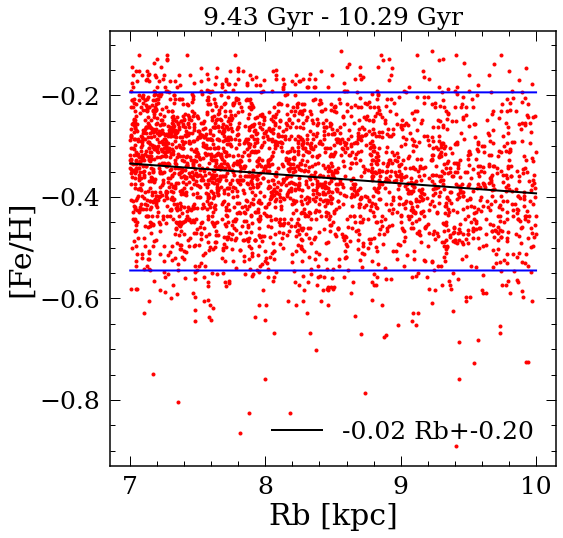

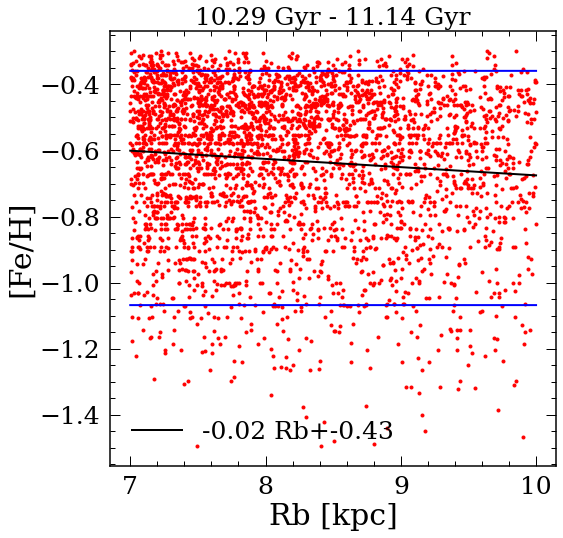

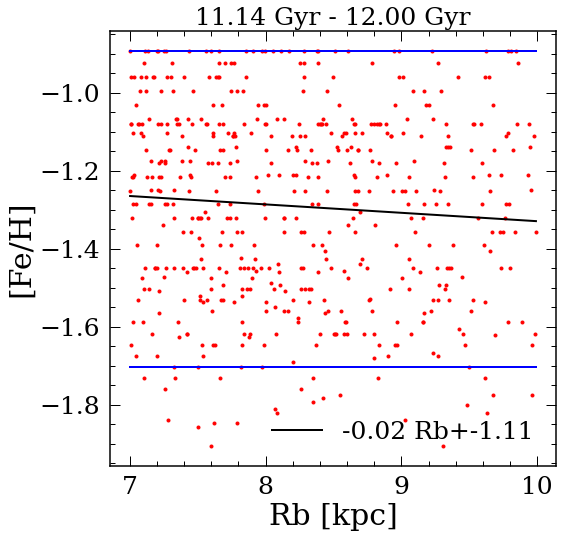

In [1511]:
import warnings
warnings.filterwarnings('ignore')


ages, slopes, fehscatter = monoage_line_range(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,12,15),
                                        xlims=[0,25],ylims=[-2,2])


2.9242175 0.9703703


100%|██████████| 14/14 [00:01<00:00, 11.27it/s]


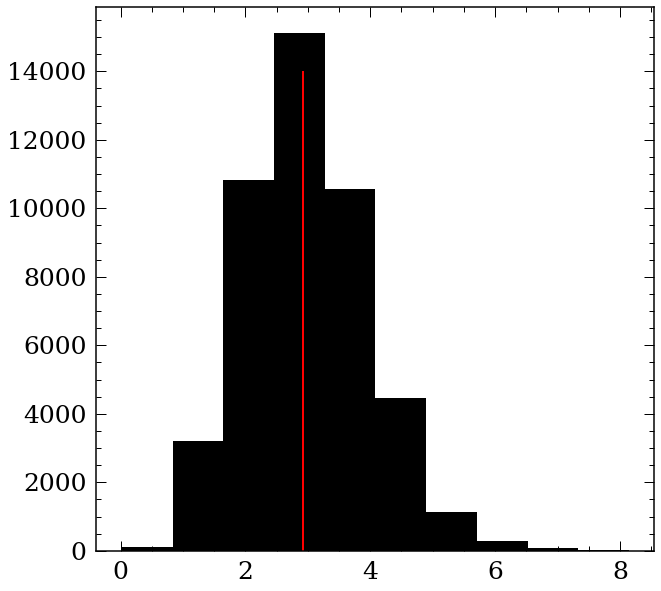

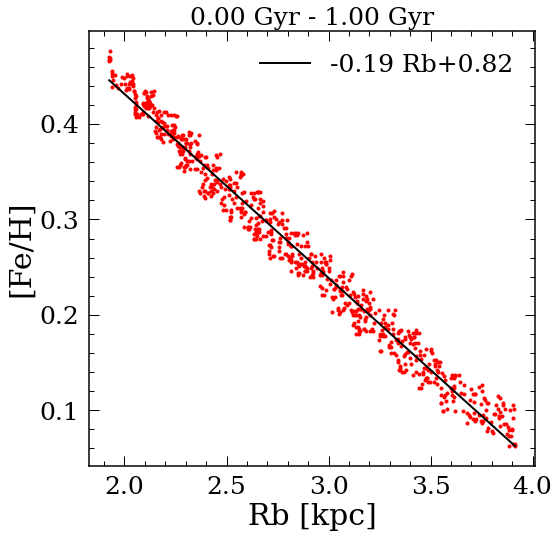

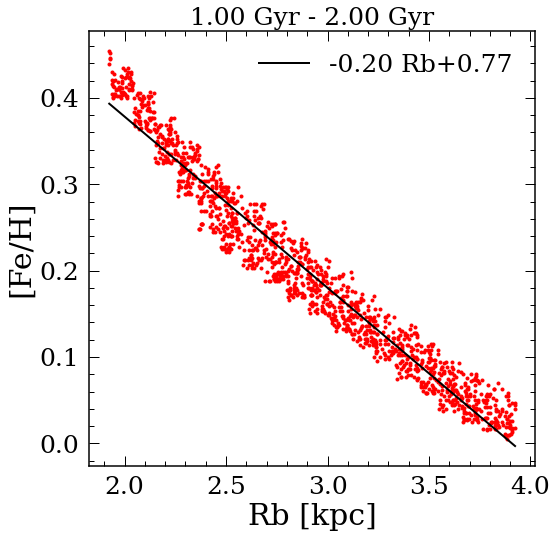

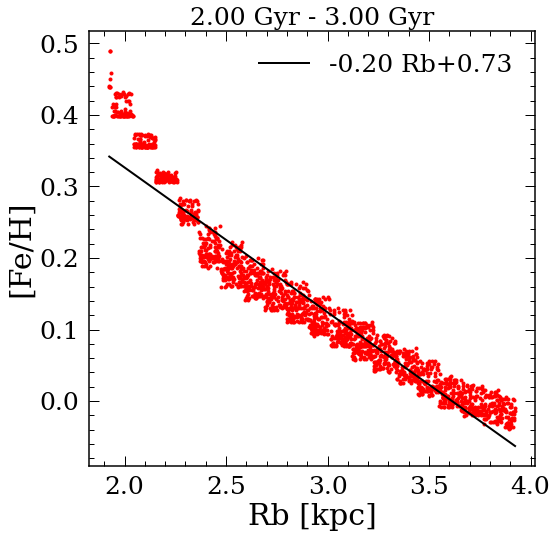

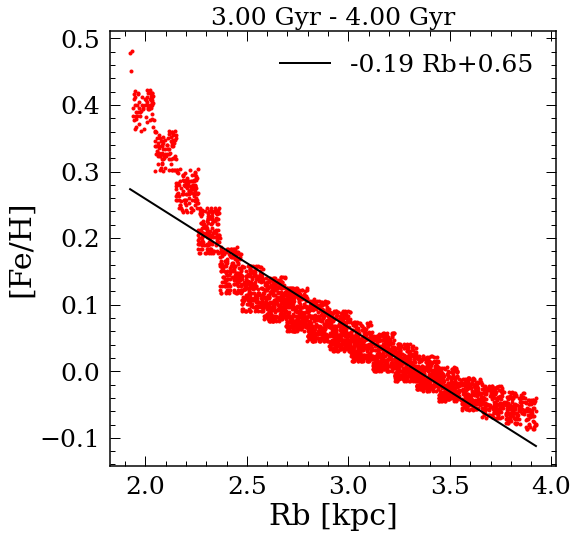

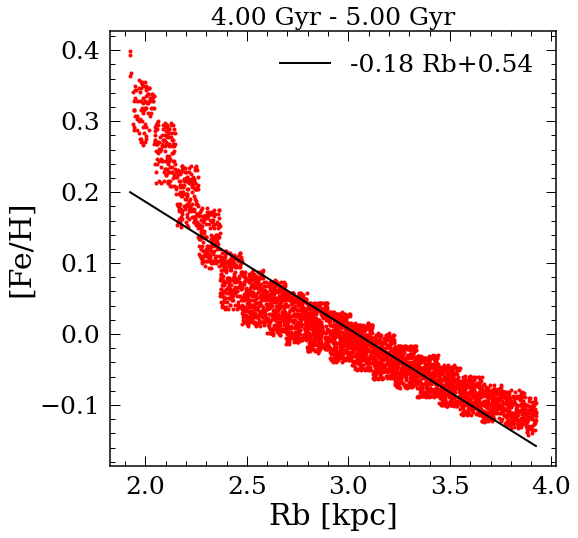

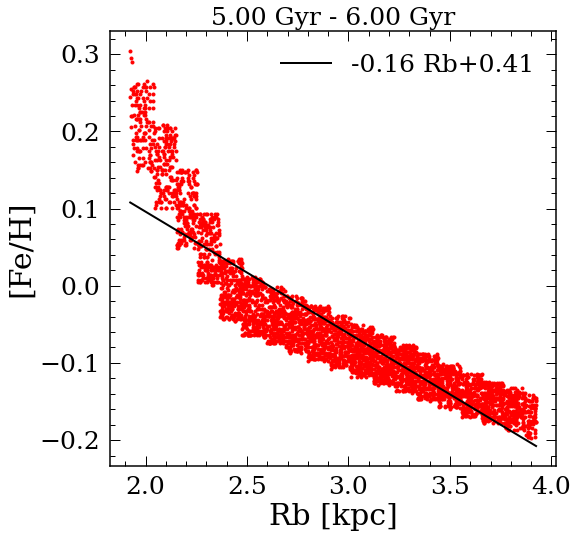

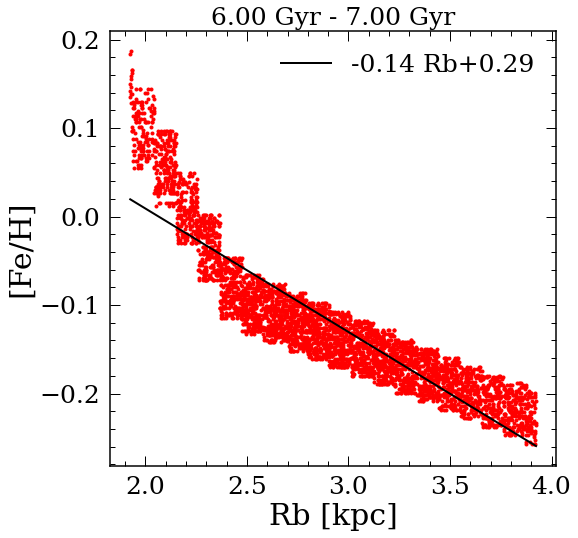

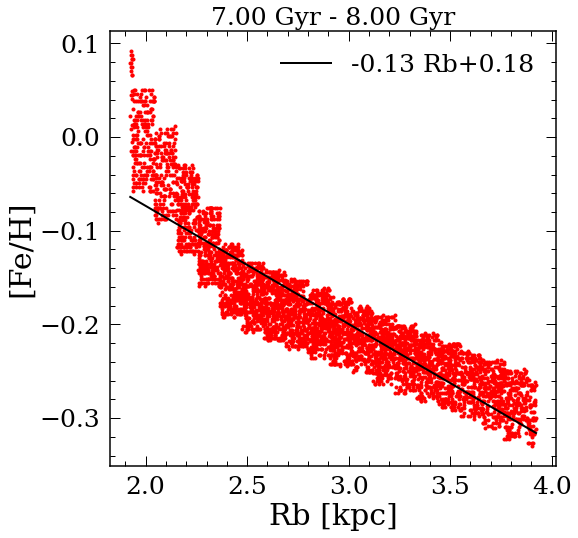

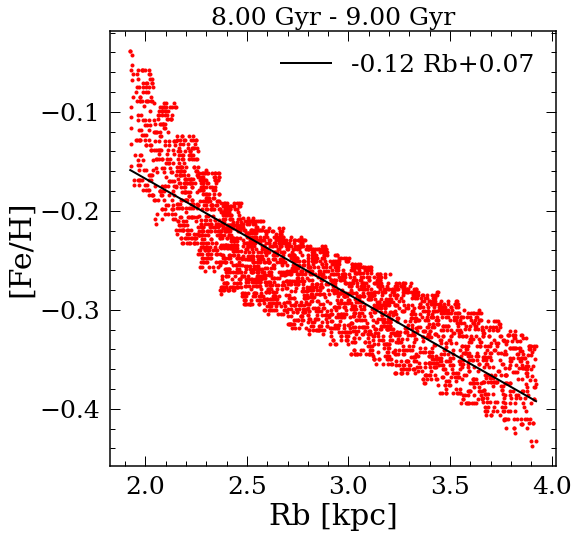

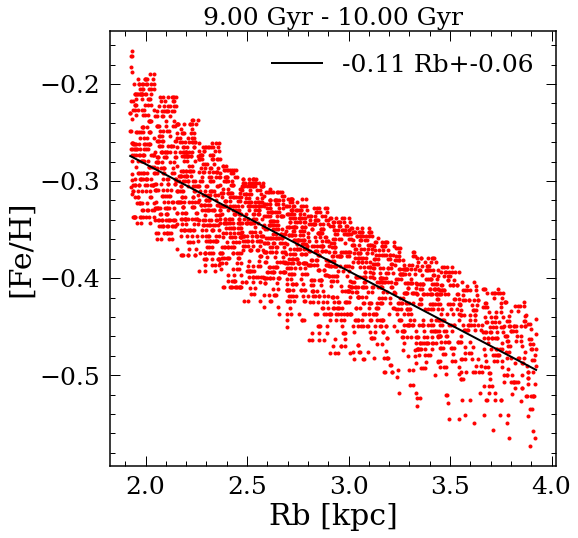

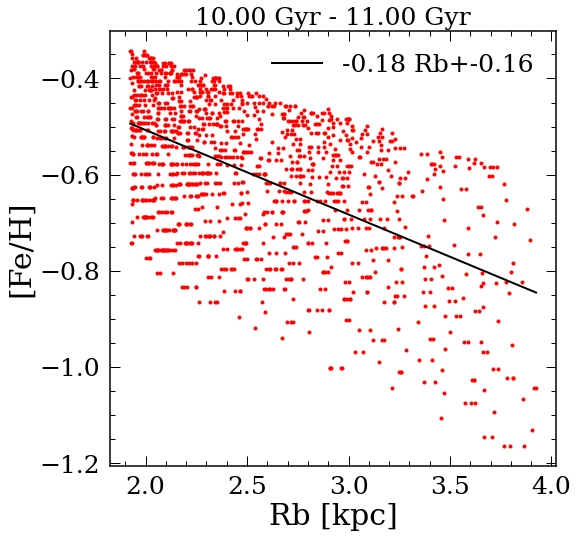

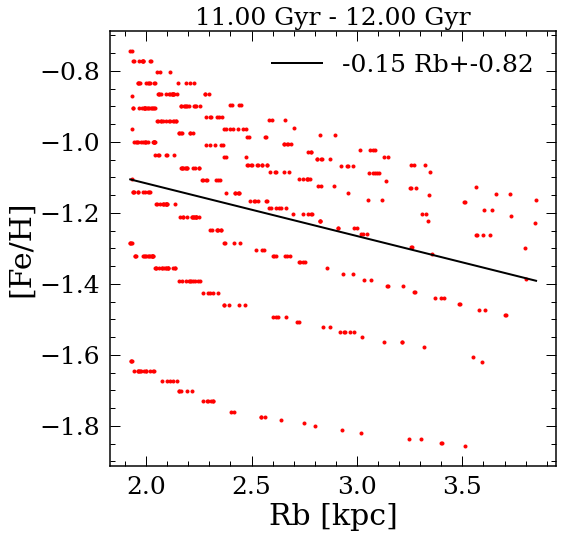

In [1512]:
plt.hist(data['ri'].values[m], color='k')
plt.vlines(np.median(data['ri'].values[m]), ymin=0, ymax=14000, color='r')
print(np.median(data['ri'].values[m]), np.std(data['ri'].values[m]))

medrb = np.median(data['ri'].values[m])
stdrb = np.std(data['ri'].values[m])
                  

#xlims = [5,9]
#m = (data['R_bir']>3)&(data['R_bir']<10)
#m = m&(abs(data['z'])<1)
"""xlims = [5,8]
ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['ri'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,12,15),
                                                 xlims=xlims)
"""
xlims = [medrb-1,medrb+1]
ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['ri'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,15),
                                                 xlims=xlims)


(0.0, 11.5)

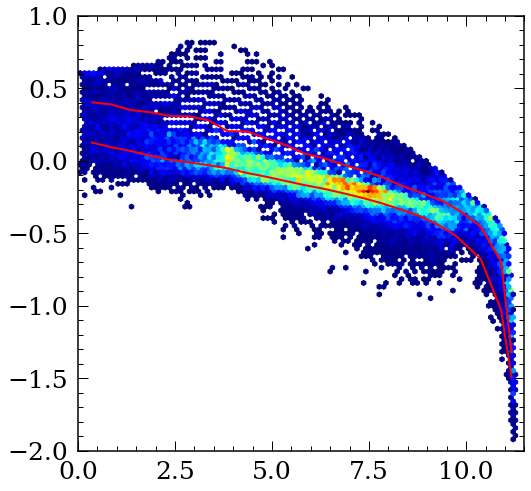

In [1513]:
plt.figure(figsize=(8,8))
plt.hexbin(data['age'][m], data['feh'][m], extent=(0,11.5,-2,1),
          mincnt=1, cmap='jet')

data = data.sort_values('age')
"""age, feh = movingMed_time(data['age'][m], data['feh'][m], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r--')

m2 = m&((data['ri']>7.9)&(data['ri']<8.1))
age, feh = movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r-')
"""

m2 = m&(data['ri']>xlims[1]-0.5)&(data['ri']<xlims[1])
age_outer, feh_outer= movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age_outer!=0)
plt.plot(age_outer[eq], feh_outer[eq], 'r-')

from scipy.interpolate import interp1d
intout = interp1d(age_outer[eq], feh_outer[eq])

m2 = m&(data['ri']<xlims[0]+0.5)&(data['ri']>xlims[0])
age, feh = movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r-')

intin = interp1d(age[eq], feh[eq])
plt.ylim([-2,1])
plt.xlim([0,11.5])



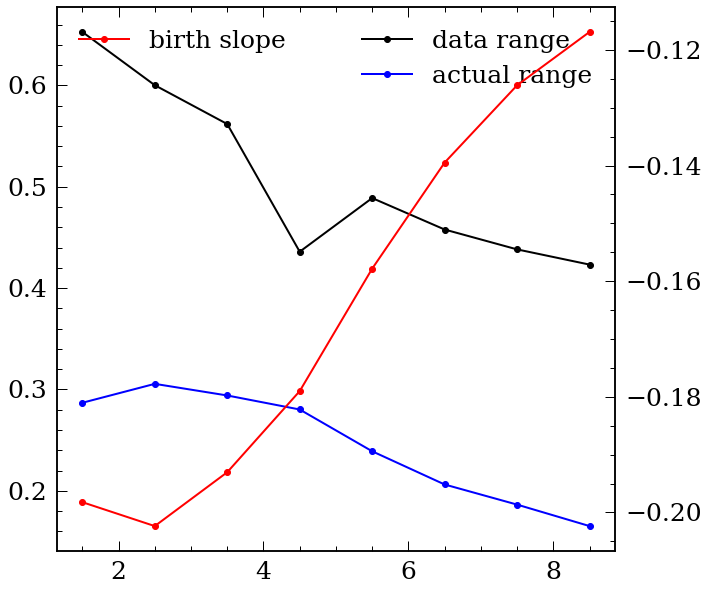

In [1514]:
m = (ages>1)&(ages<9)
plt.plot(ages[m], (fehscatter)[m], 'k-o', label='data range')
plt.plot(ages[m], (intin(ages[m])-intout(ages[m])), 'b-o', label='actual range')
plt.legend(loc=1)
plt.twinx()
plt.plot(ages[m], slopes_rbir[m], 'r-o', label='birth slope')
plt.legend(loc=2)

In [1515]:
print(ages[m])

[1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5]


((-0.9917420078976671, 1.399167484370055e-06),
 (-0.8273743072072196, 0.01125290623831569))

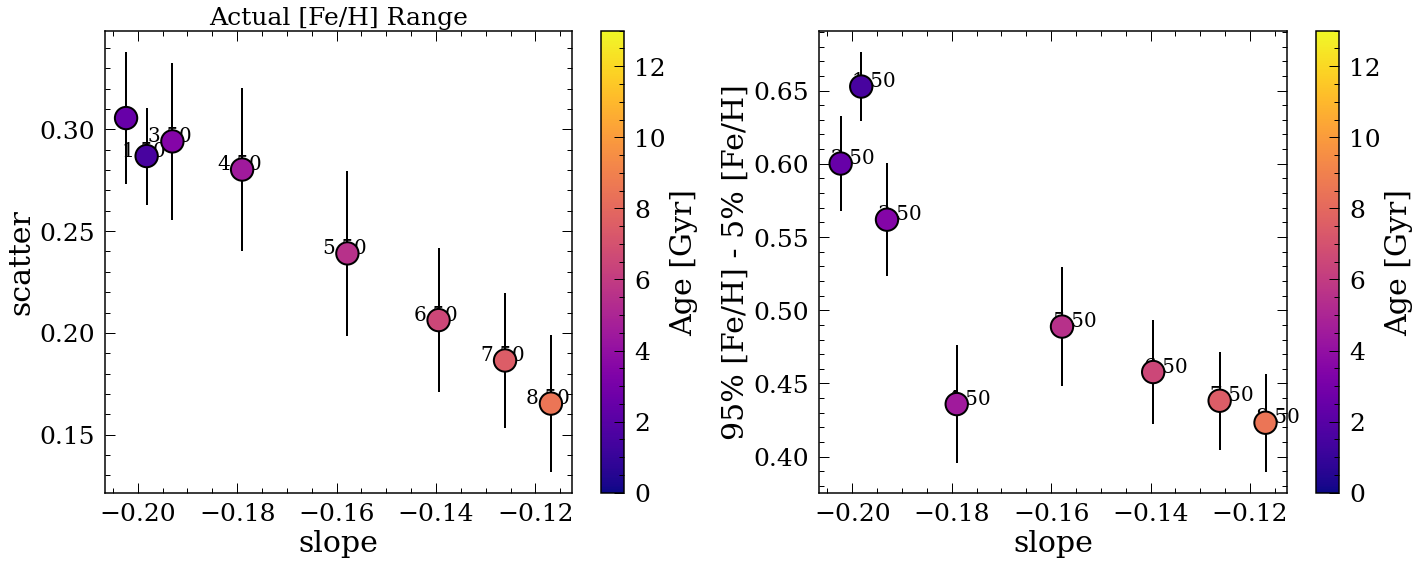

In [1516]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.scatter(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]), c=ages[m],
           s=500,  edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]),
             yerr=fehscatter_rbir[m], fmt='ko',
            zorder=1)
plt.xlabel('slope')
plt.ylabel('scatter')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Actual [Fe/H] Range', fontsize=25)
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.005, 
                            (intin(ages[m])-intout(ages[m]))[i]), 
                 fontsize=20,color='k')

plt.subplot(1,2,2)
plt.scatter(slopes_rbir[m], 
         fehscatter[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         fehscatter[m],
             yerr=fehscatter_rbir[m], fmt='ko',
            zorder=1)
plt.xlabel('slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.002, fehscatter[m][i]), 
                 fontsize=20,color='k')
plt.tight_layout()

#plt.title('Data [Fe/H] Range', fontsize=25)


scipy.stats.pearsonr(slopes_rbir[m], (intin(ages[m])-intout(ages[m]))), scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])

((-0.9917420078976671, 1.399167484370055e-06),
 (-0.8273743072072196, 0.01125290623831569))

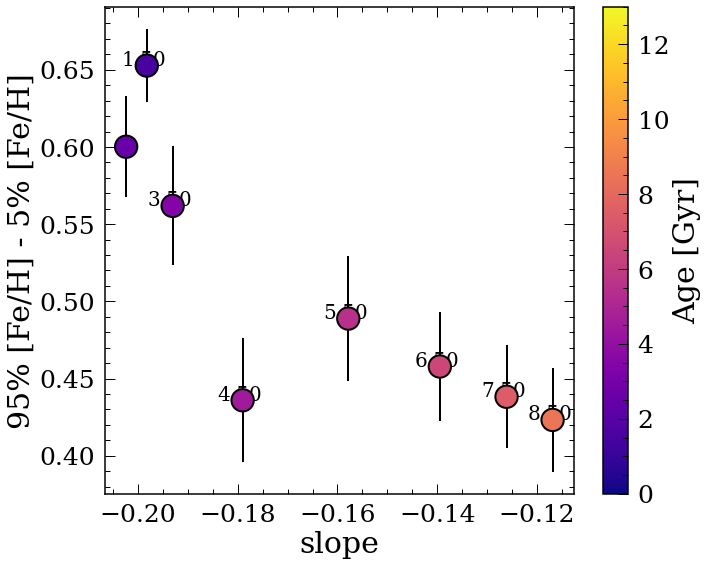

In [1517]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
#m = (ages>1)&(ages<10.5)
"""plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.scatter(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]), c=ages[m],
           s=500,  edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma')
plt.xlabel('slope')
plt.ylabel('scatter')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Actual [Fe/H] Range', fontsize=25)
"""

plt.figure(figsize=(10,8))
plt.scatter(slopes_rbir[m], 
         fehscatter[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         fehscatter[m],
             yerr=fehscatter_rbir[m], fmt='ko',
            zorder=1)
plt.xlabel('slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.tight_layout()
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.005, fehscatter[m][i]), 
                 fontsize=20,color='k')
#plt.title('Data [Fe/H] Range', fontsize=25)


scipy.stats.pearsonr(slopes_rbir[m], (intin(ages[m])-intout(ages[m]))), scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])

# UHD-NIHAO

In [69]:
simNo='2_79e12'
z='0' 
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5

if simNo=='data':
    data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
    data['z_today']=data['z']
    data['x_today']=data['X']
    data['y_today']=data['Y']
    data['feh_scale']=data['M_H']
    data['ofe_scale']=data['O_FE']
    data['age']=data['Age']
elif select:
    data=pd.read_pickle('Data/Buck_g'+simNo+'_apogee_selec.pkl')
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
elif not select:
    if z=='0':
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'.pkl')
        #rg = pd.read_pickle('../NIHAORbirth/g'+simNo.split('_')[0]+'.'+simNo.split('_')[1]+'_z_0_decomp.pkl')
        #data = pd.merge(data, rg[['iord','Rg']], left_on='iord', right_on='iord',
        #               how='inner')
    else:
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
        try:
            data['x_today']=data['x']
            data['y_today']=data['y']
            data['z_today']=data['z']
        except:
            print(np.shape(data['x_today']))
        
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
    
        
vscale = 240/340
rscale = 3.5/5.6
data['vx'] = data['vx']*vscale
data['vy'] = data['vy']*vscale
data['vz'] = data['vz']*vscale

data['R'] = data['R']*rscale
#data['Rg'] = data['Rg']*rscale
data['R_bir'] = data['R_bir']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale

data['Jr'] = data['Jz']*rscale*rscale
data['Jphi'] = data['Jphi']*rscale*rscale
data['Jz'] = data['Jz']*rscale*rscale

if Rcut:
    data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
    data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        
data.columns

Index(['vx_birth', 'vy_today', 'vz_today', 'z_today', 'vy_birth', 'ofe',
       'iords', 'vx_today', 'x_today', 'feh', 'x_birth', 'y_birth', 'vz_birth',
       'mass', 'y_today', 'oxh', 'z_birth', 'age', 'iord', 'vx', 'vy', 'vz',
       'x', 'y', 'z', 'Jr', 'Jphi', 'Jz', 'R', 'R_bir', 'feh_scale',
       'ofe_scale'],
      dtype='object')

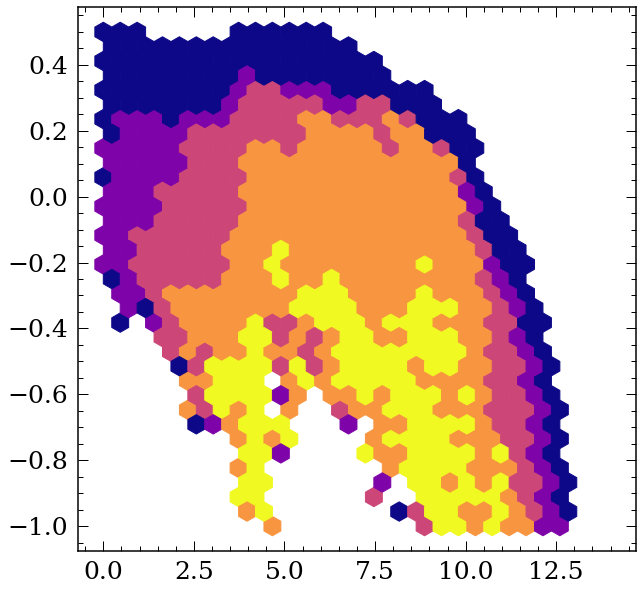

In [70]:
plt.hexbin(data['age'], data['feh'], C=abs(data['R']),
          extent=(0,14,-1,0.5),vmin=0,vmax=5, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',5),
          reduce_C_function=np.std)


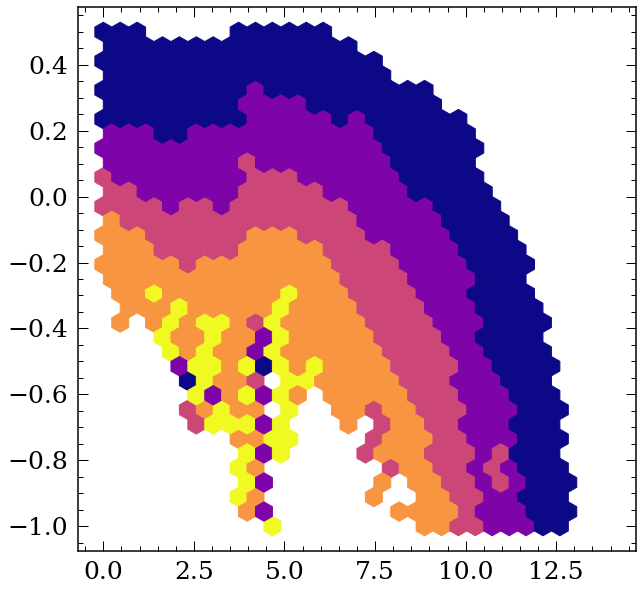

In [71]:
plt.hexbin(data['age'], data['feh'], C=abs(data['R_bir']),
          extent=(0,14,-1,0.5),vmin=0,vmax=15, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',5))


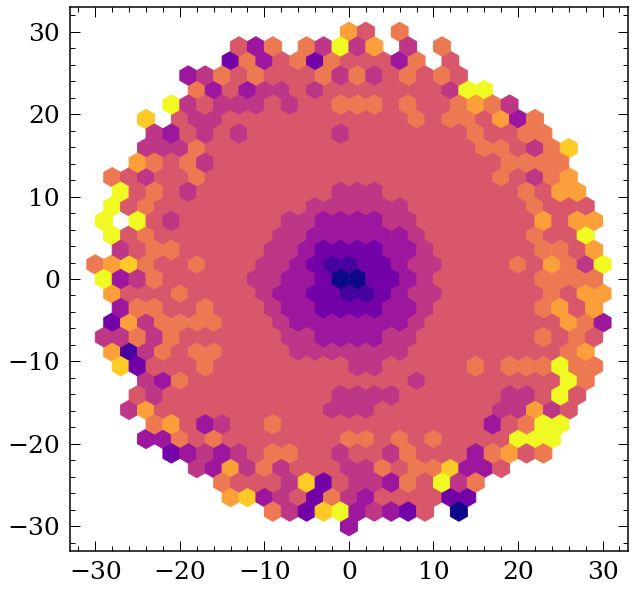

In [72]:
plt.hexbin(data['x'], data['y'], C=abs(data['R_bir']),
          extent=(-30,30,-30,30),vmin=0,vmax=15, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',10))



100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


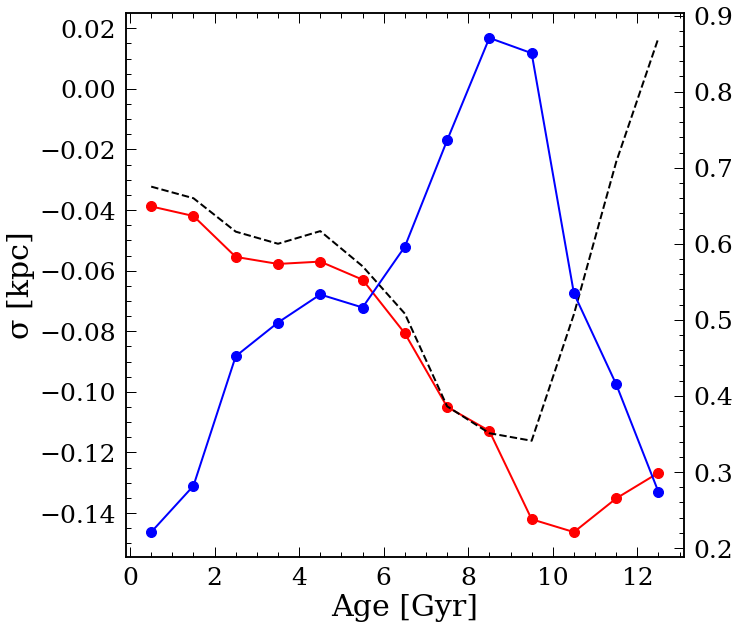

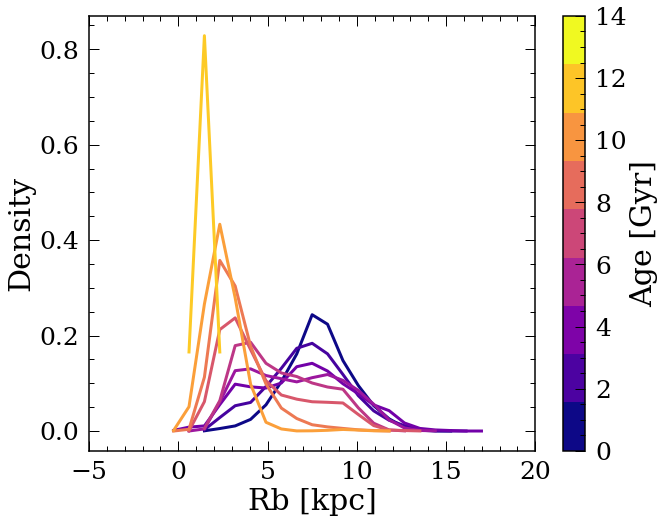

In [132]:
xlims = [7,10]
m = (data['R']>xlims[0])&(data['R']<xlims[1])
m = m&(abs(data['z'])<0.5)
m = m&(data['feh']>-1)
#m = m&((data['ri']>xlims[0])&(data['ri']<xlims[1]))



agebin = np.linspace(0,13,14)

bslope = np.zeros(len(agebin)-1)
dsize = np.zeros(len(agebin)-1)
fehr = np.zeros(len(agebin)-1)
for i in trange(len(agebin)-1):
    m2 = (data[m]['age']>agebin[i])&(data[m]['age']<agebin[i+1])
    data_sing = data[m][m2].dropna()
    #plt.plot(agebin[i]/2+agebin[i+1]/2,
    #         np.std(data_sing['R']-data_sing['R_bir']),'ro', markersize=30)
    #dsize[i] = (np.percentile(data_sing['R_bir'],95)-np.percentile(data_sing['R_bir'],5))
    dsize[i] = (np.percentile(data_sing['R_bir'],95)-np.percentile(data_sing['R_bir'],5))
    fehr[i] = (np.percentile(data_sing['feh'],95)-np.percentile(data_sing['feh'],5))
    bslope[i] = -(np.percentile(data_sing['feh'],95)-np.percentile(data_sing['feh'],5))/dsize[i]
    #print(agebin[i]/2+agebin[i+1]/2, np.percentile(data_sing['R_bir'],95)-np.percentile(data_sing['R_bir'],5))
plt.xlabel('Age [Gyr]')
plt.ylabel('σ [kpc]')

plt.plot(agebin[1:]/2+agebin[:-1]/2, 
             bslope, 
             'ro-', markersize=10)

plt.plot(agebin[1:]/2+agebin[:-1]/2, 
             slopes_rbir, 
             'k--', markersize=10)

plt.twinx()
plt.plot(agebin[1:]/2+agebin[:-1]/2, 
             fehr, 
             'bo-', markersize=10)

data_rbdis = data[m]
agebin_Rb = np.linspace(0,14,10)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
for i in range(len(agebin_Rb)-1):
    sub_sing = data_rbdis.loc[(data_rbdis['age']>agebin_Rb[i])&(data_rbdis['age']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['R_bir'], 
                            bins=np.linspace(-5,20,30), density=True)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.xlim([-5,20])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')

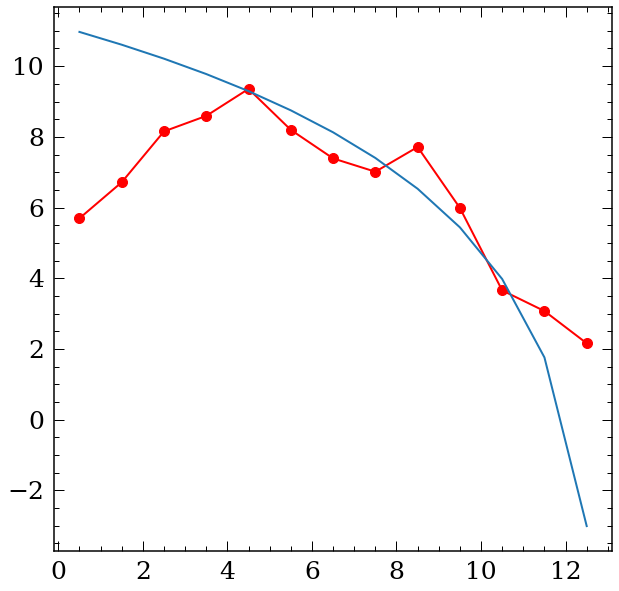

In [152]:
plt.plot(agebin[1:]/2+agebin[:-1]/2, 
             dsize, 'ro-', markersize=10)
plt.plot(agebin[1:]/2+agebin[:-1]/2, np.array([math.log(13-i,100) for i in ages])*20)


100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


<Figure size 1440x576 with 0 Axes>

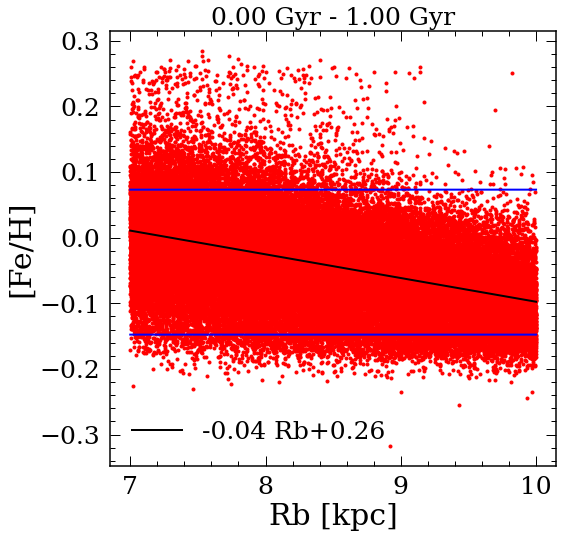

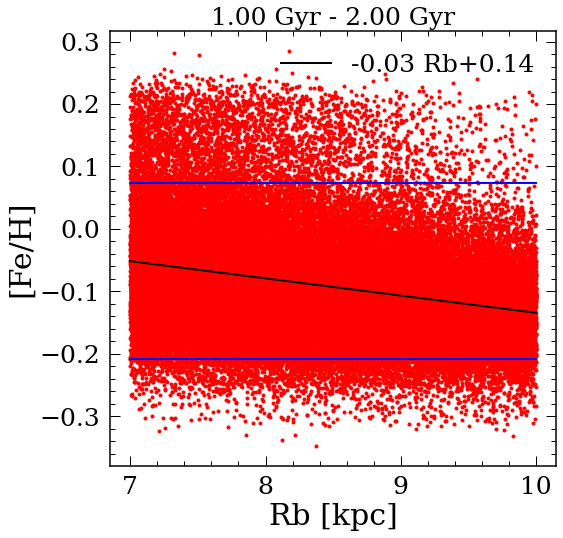

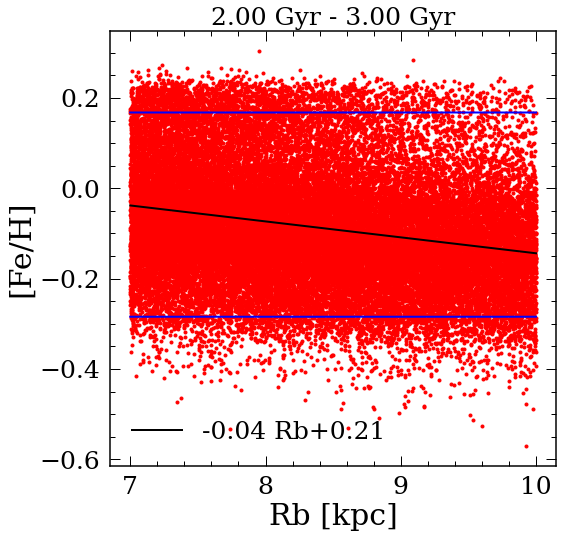

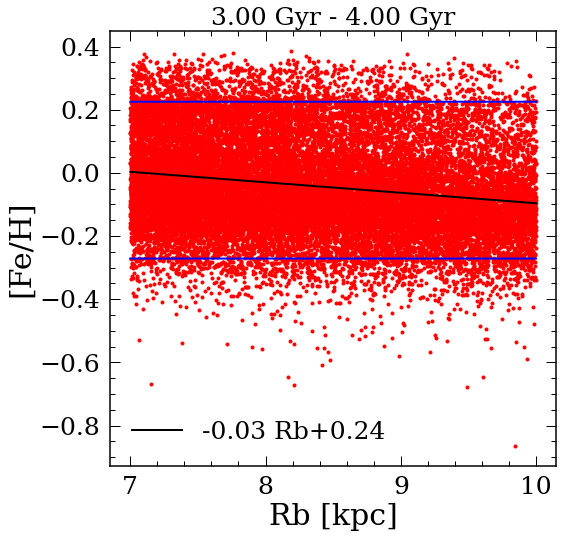

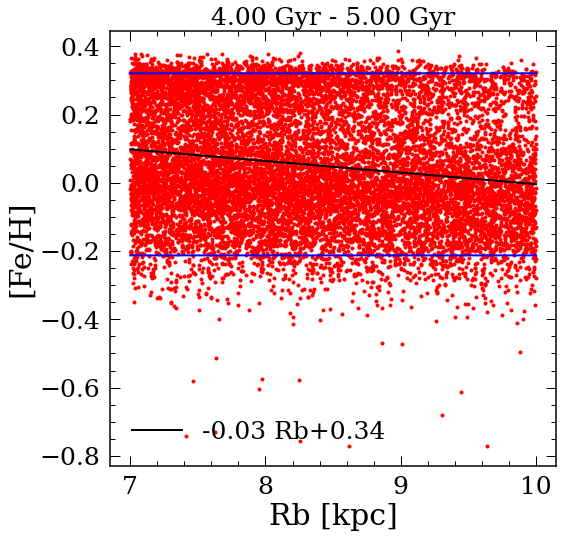

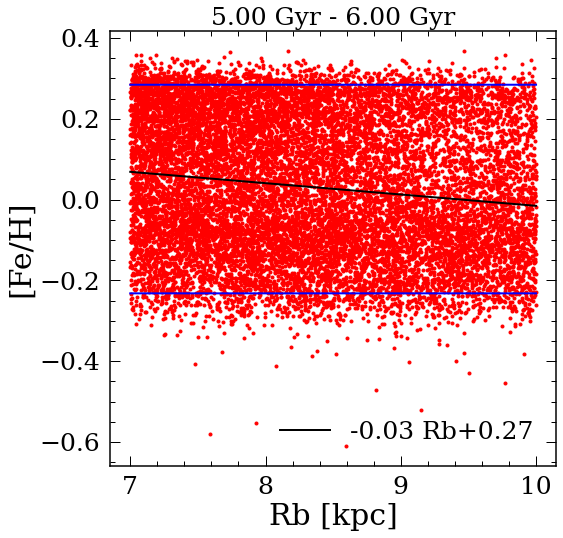

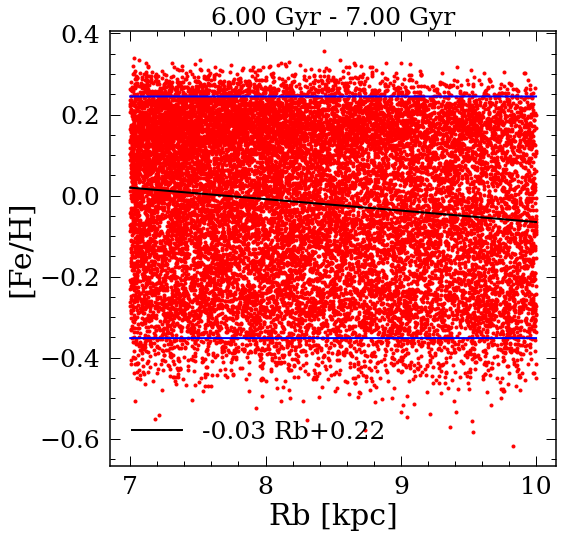

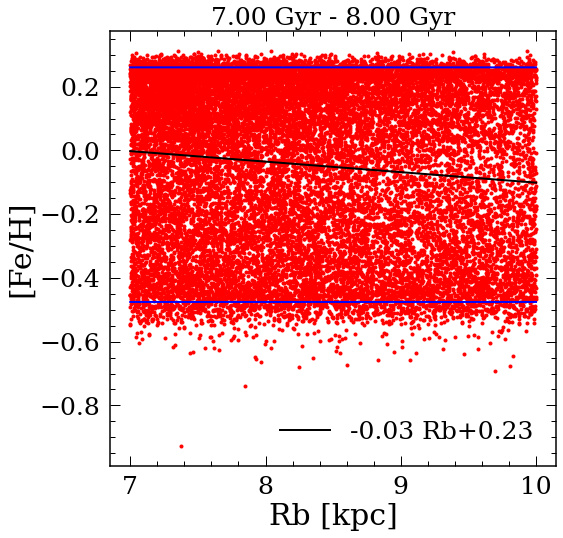

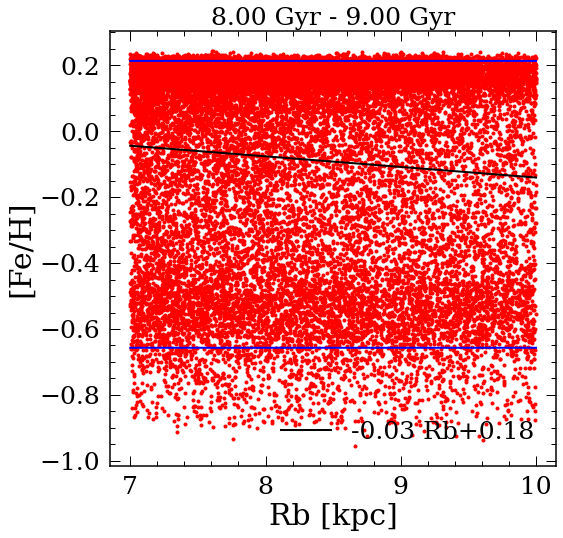

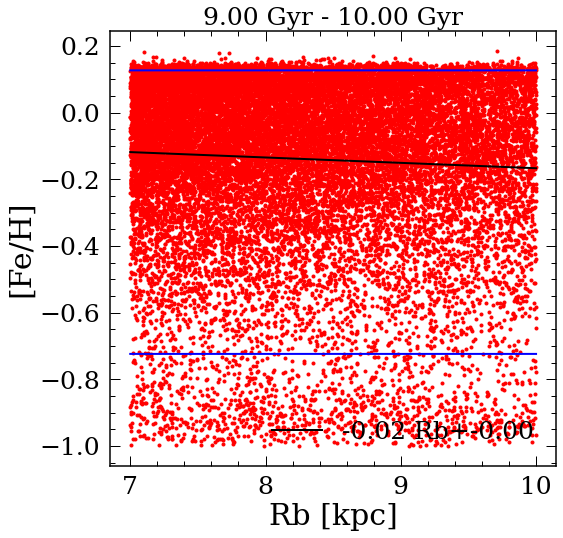

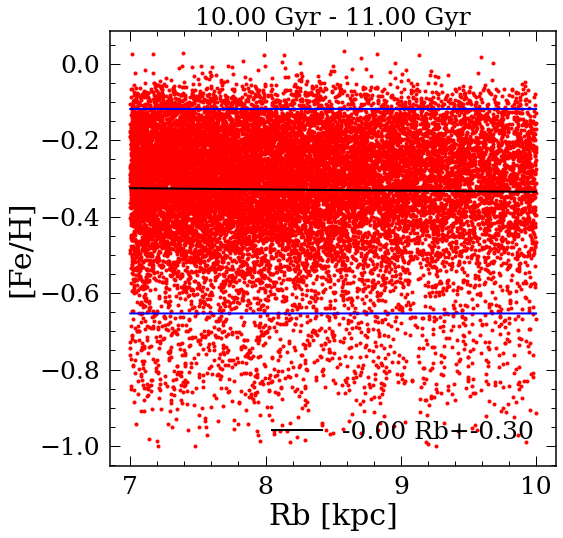

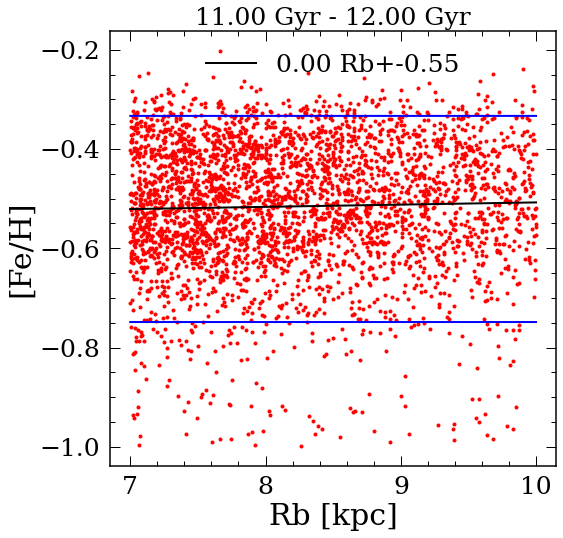

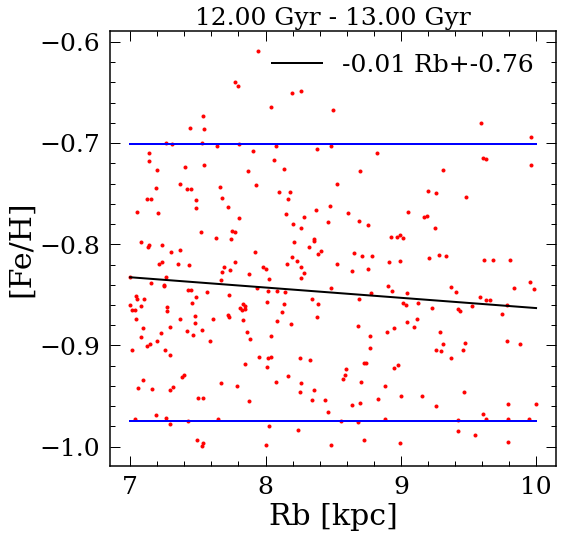

In [125]:
import warnings
warnings.filterwarnings('ignore')

m = (data['R']>xlims[0])&(data['R']<xlims[1])
m = m&(abs(data['z'])<0.5)
m = m&(data['feh']>-1)
ages, slopes, fehscatter = monoage_line_range(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,13,14),
                                        xlims=xlims,ylims=[-2,2])






6.7459448343991735 2.6348229049903633


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


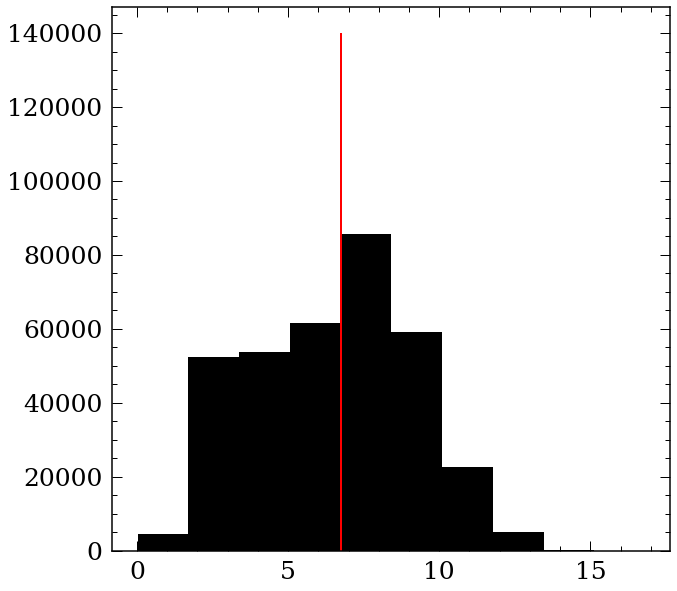

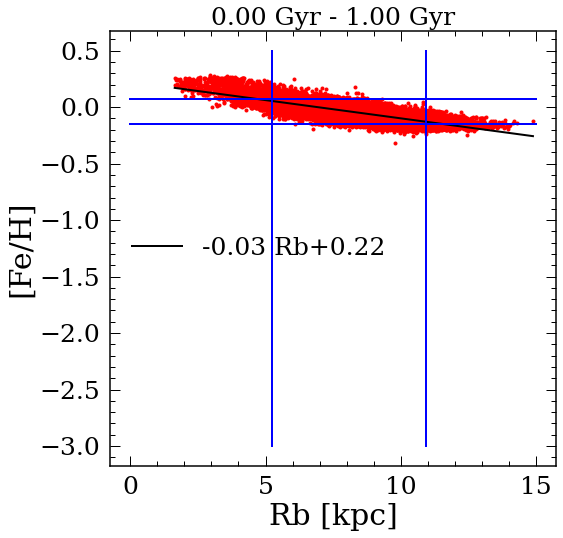

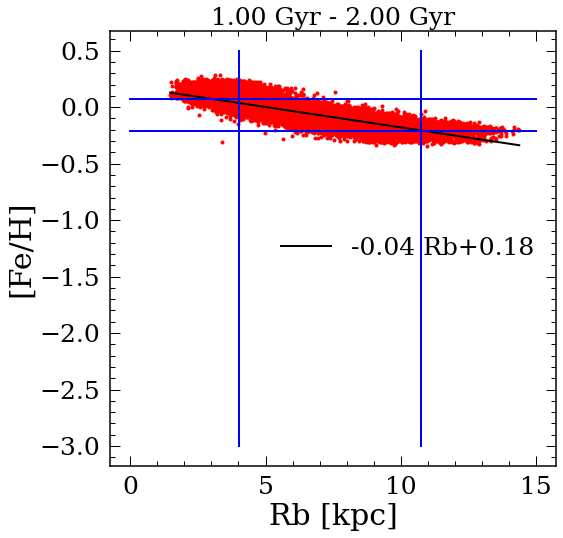

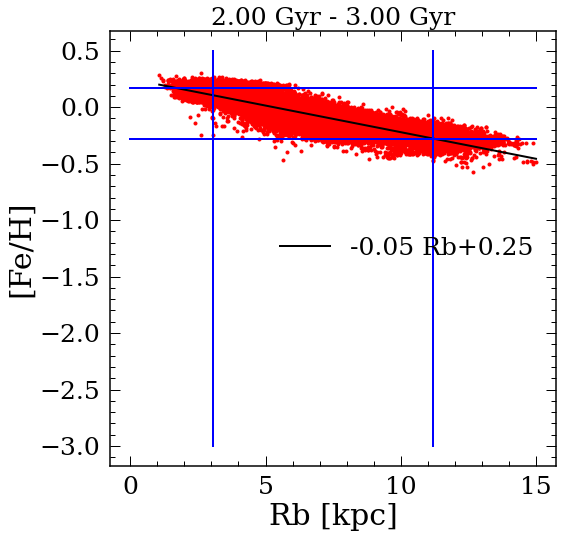

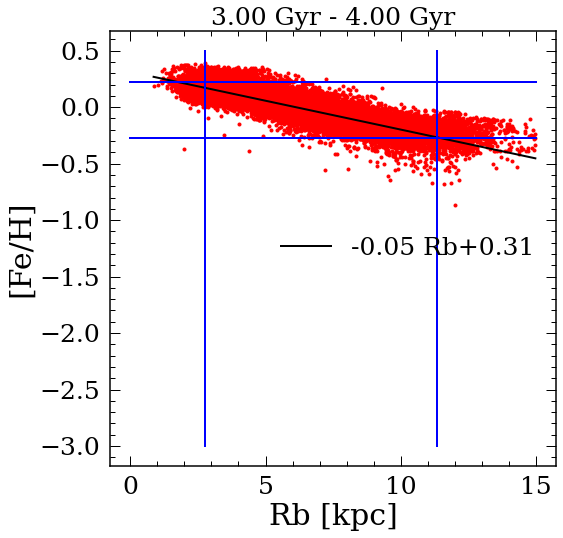

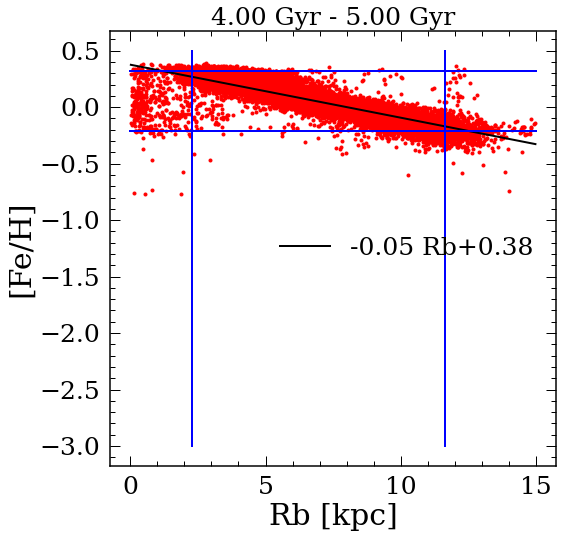

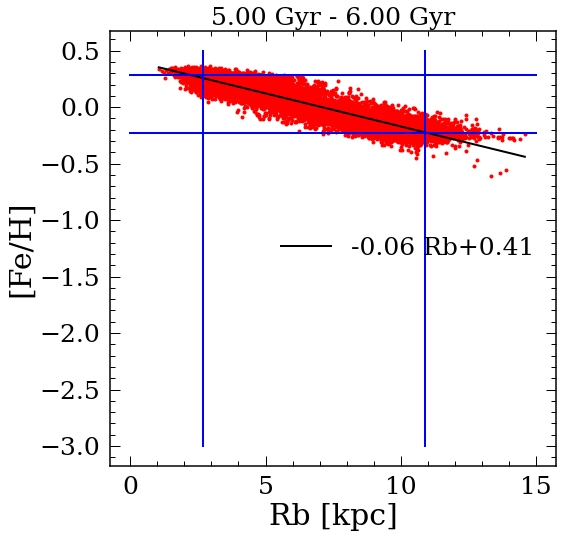

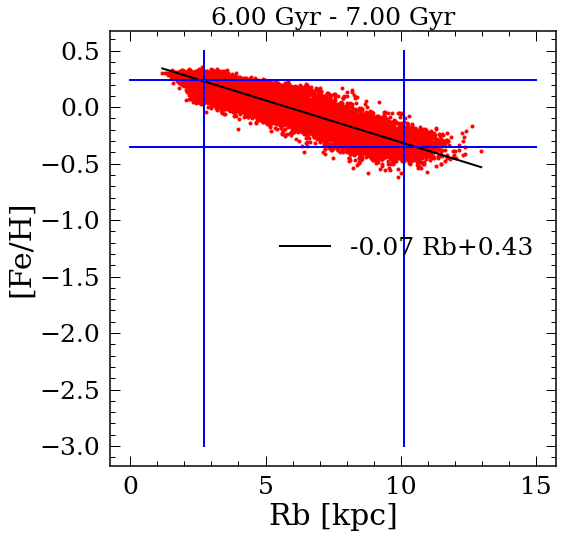

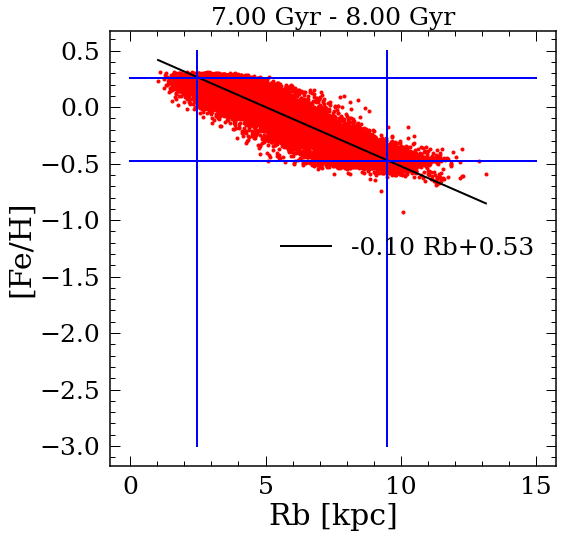

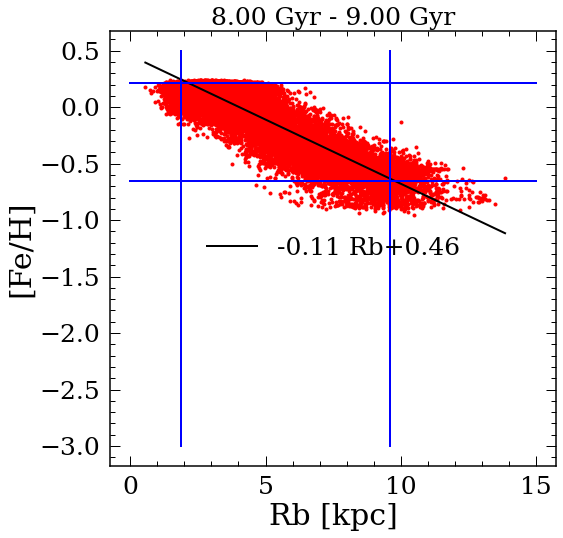

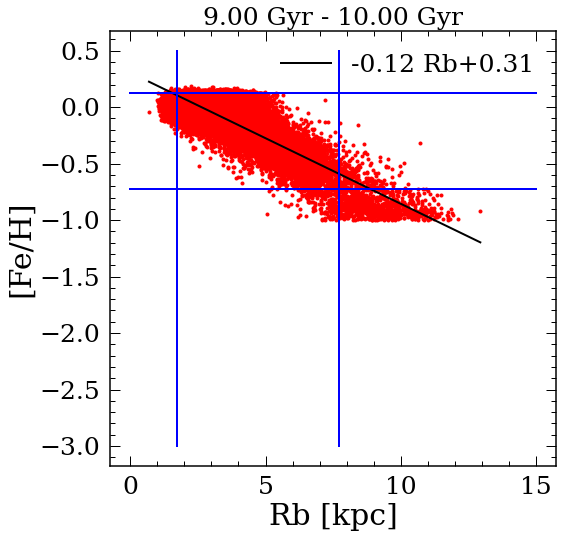

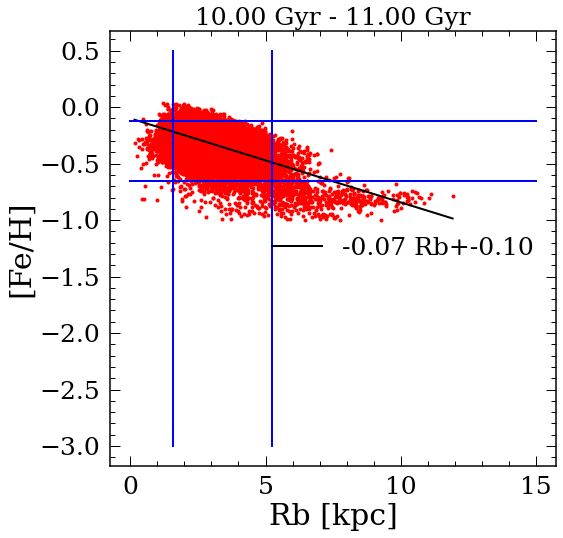

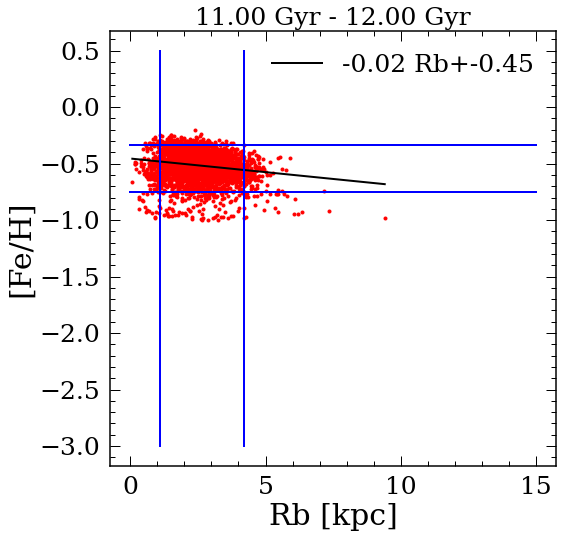

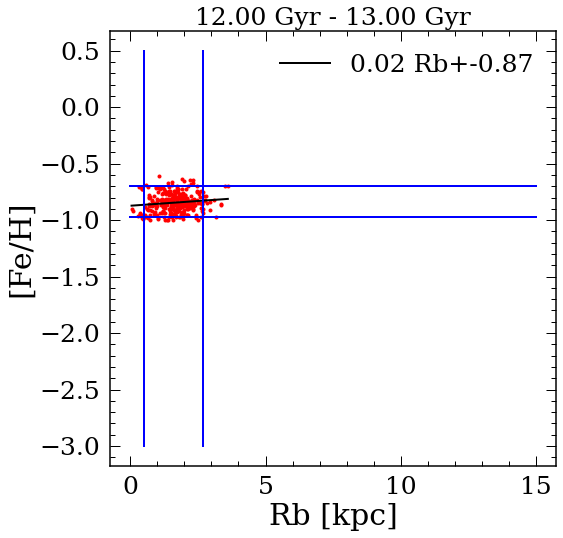

In [126]:
plt.hist(data['R_bir'].values[m], color='k')
plt.vlines(np.median(data['R_bir'].values[m]), ymin=0, ymax=140000, color='r')
print(np.median(data['R_bir'].values[m]), np.std(data['R_bir'].values[m]))

medrb = np.median(data['R_bir'].values[m])
stdrb = np.std(data['R_bir'].values[m])
                  

#xlims = [5,9]
#m = (data['R_bir']>3)&(data['R_bir']<10)
#m = m&(abs(data['z'])<1)

"""ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,15),
                                                 xlims=[medrb-1,
                                                        medrb+1])"""

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,13,14),
                                                 xlims=[0,15])

0.0 7.962058474441064
1.0 9.627411960906096
2.0 10.425683278802058
3.0 10.653185532462393
4.0 12.287096872128053
5.0 9.819526600891631
6.0 8.791530053998445
7.0 8.57194591899184
8.0 9.23761502882659
9.0 9.129625500294097
10.0 8.439754184357389
11.0 7.464872791330444
12.0 19.52860519083563
13.0 26.659251768757095


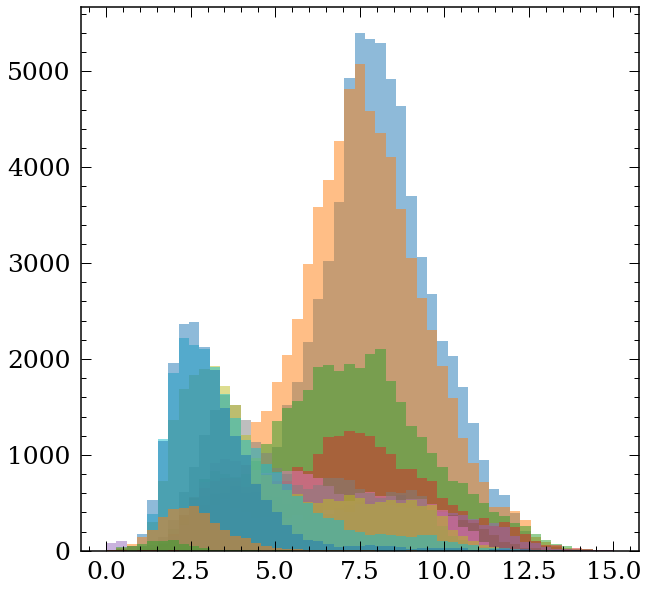

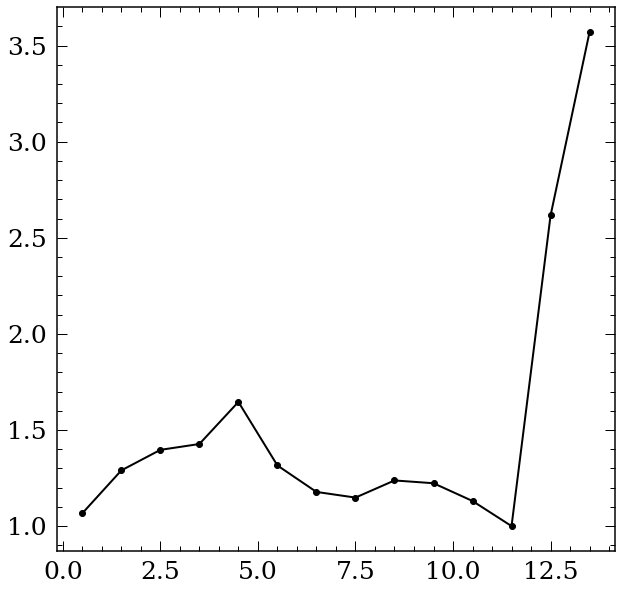

In [58]:
data_sn = data.loc[(data['R']>7)&(data['R']<10)]
data_sn = data_sn.loc[abs(data_sn['z'])<0.5].reset_index(drop=True)

diffstars = np.zeros(len(agebin_plt)-1)

agebin_plt = np.linspace(0,14,15)
for i in range(len(agebin_plt)-1):
    data_sing = data_sn.loc[(data_sn['age']>agebin_plt[i])&(data_sn['age']<agebin_plt[i+1])]
    plt.hist(data_sing['R_bir'], bins=np.linspace(0,15,50),
            alpha=0.5)
    diffstars[i] = np.percentile(data_sing['R_bir'],99)-np.percentile(data_sing['R_bir'],1)
    print(agebin_plt[i], diffstars[i])
    
    
plt.figure()
plt.plot((agebin_plt[:-1]+agebin_plt[1:])/2, diffstars/min(diffstars), 'ko-')


/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.0, 14.0)

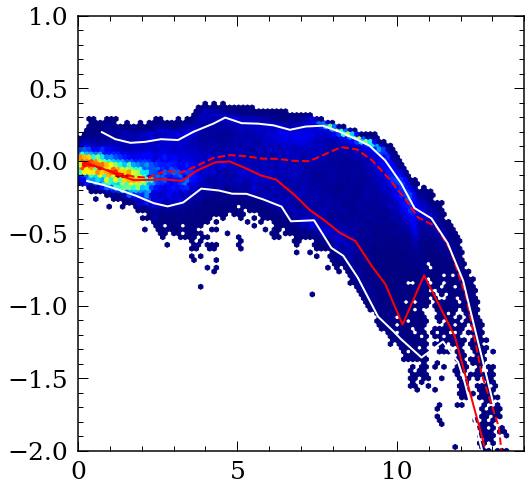

In [62]:
m = (data['R']>xlims[0])&(data['R']<xlims[1])
m = m&(abs(data['z'])<0.5)

plt.figure(figsize=(8,8))
plt.hexbin(data['age'][m], data['feh'][m], extent=(0,14,-2,1),
          mincnt=1, cmap='jet')

data = data.sort_values('age')
age, feh = movingMed_time(data['age'][m], data['feh'][m], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r--')

m2 = m&((data['R_bir']>7.9)&(data['R_bir']<8.1))
age, feh = movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'r-')

m2 = m&(data['R_bir']>12)
age_outer, feh_outer= movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age_outer!=0)
plt.plot(age_outer[eq], feh_outer[eq], 'w-')

from scipy.interpolate import interp1d
intout = interp1d(age_outer[eq], feh_outer[eq])

m2 = m&(data['R_bir']<3)
age, feh = movingMed_time(data['age'][m2], data['feh'][m2], 0.4, 0.5)
eq = (age!=0)
plt.plot(age[eq], feh[eq], 'w-')

intin = interp1d(age[eq], feh[eq])
plt.ylim([-2,1])
plt.xlim([0,14])




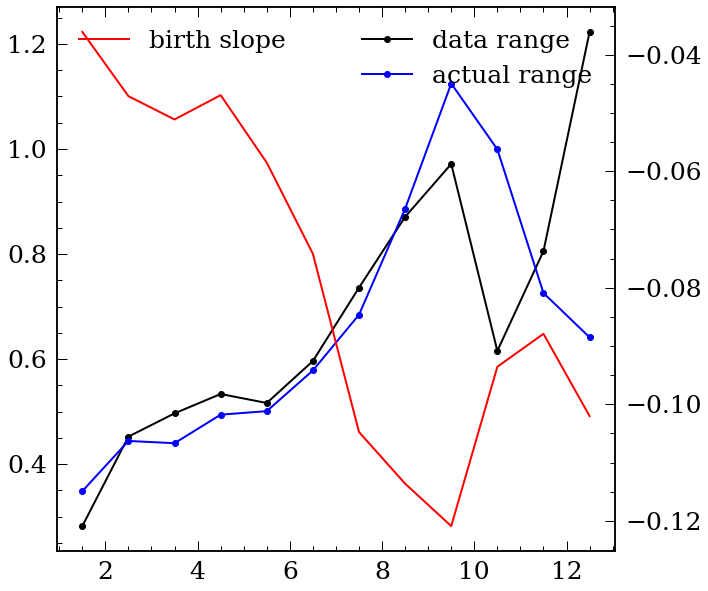

In [1296]:
m = (ages>0.5)&(ages<13.5)
plt.plot(ages[m], (fehscatter)[m], 'k-o', label='data range')
plt.plot(ages[m], (intin(ages[m])-intout(ages[m])), 'b-o', label='actual range')
plt.legend(loc=1)
plt.twinx()
plt.plot(ages[m], slopes_rbir[m], 'r-', label='birth slope')
plt.legend(loc=2)

((-0.875612569424828, 0.00018962928083282555),
 (-0.8439381655482983, 0.0005575656495826472))

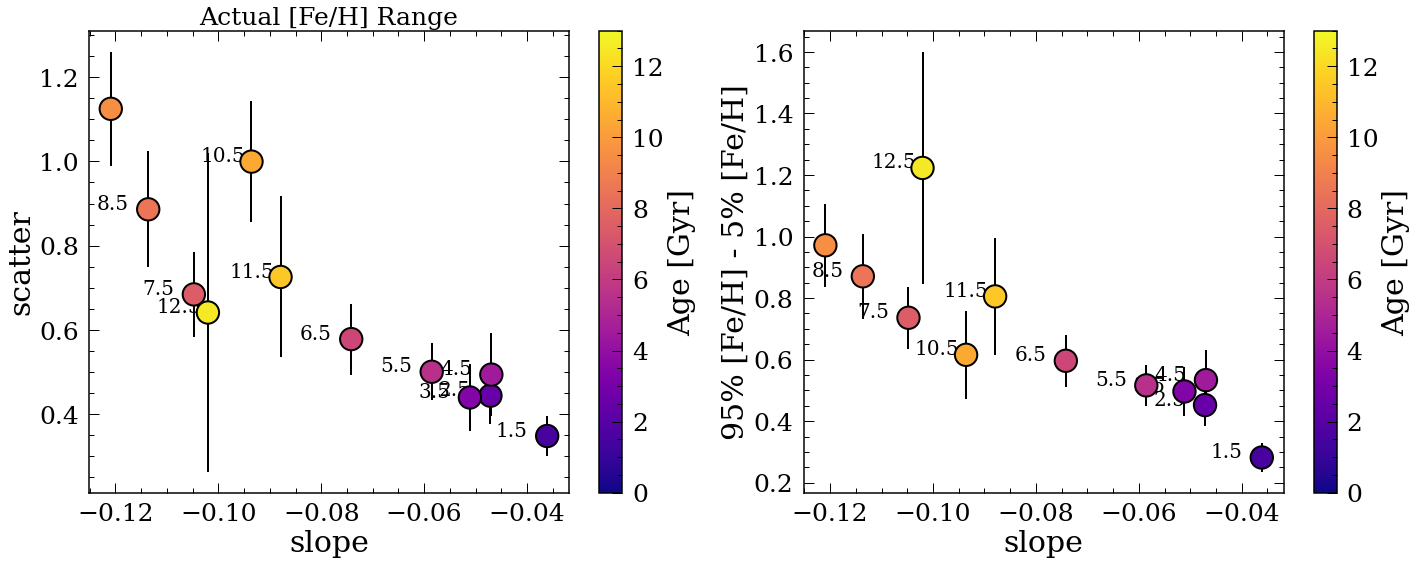

In [1297]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
#m = (ages>1)&(ages<10.5)
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.scatter(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]), c=ages[m],
           s=500,  edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]),
             yerr=fehscatter_rbir[m], fmt='ko',zorder=1)
plt.xlabel('slope')
plt.ylabel('scatter')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Actual [Fe/H] Range', fontsize=25)
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate(str(txt), (slopes_rbir[m][i]-0.01, 
                            (intin(ages[m])-intout(ages[m]))[i]), 
                 fontsize=20)

plt.subplot(1,2,2)
plt.scatter(slopes_rbir[m], 
         fehscatter[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         fehscatter[m],
             yerr=fehscatter_rbir[m], fmt='ko',zorder=1)
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate(str(txt), (slopes_rbir[m][i]-0.01, fehscatter[m][i]), 
                 fontsize=20)
    
plt.xlabel('slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.tight_layout()
#plt.title('Data [Fe/H] Range', fontsize=25)


scipy.stats.pearsonr(slopes_rbir[m], (intin(ages[m])-intout(ages[m]))), scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])

((-0.875612569424828, 0.00018962928083282555),
 (-0.8439381655482983, 0.0005575656495826472))

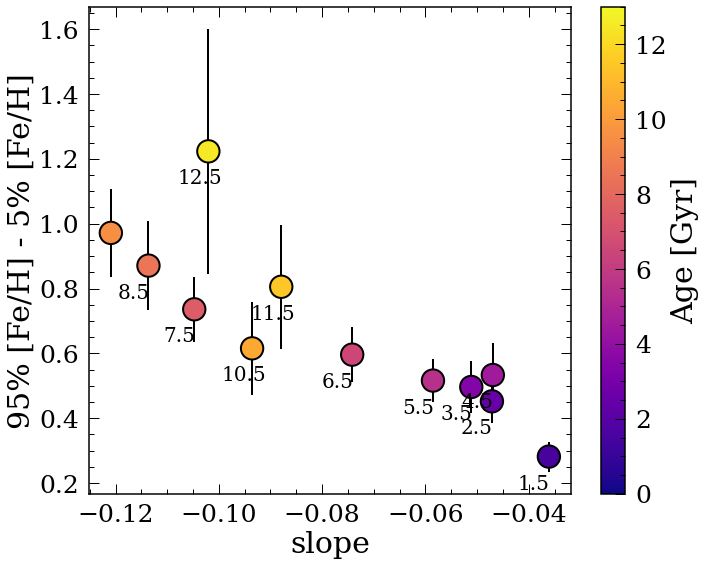

In [1304]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
#m = (ages>1)&(ages<10.5)
"""plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.scatter(slopes_rbir[m], 
         intin(ages[m])-intout(ages[m]), c=ages[m],
           s=500,  edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma')
plt.xlabel('slope')
plt.ylabel('scatter')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('Actual [Fe/H] Range', fontsize=25)
"""

plt.figure(figsize=(10,8))
plt.scatter(slopes_rbir[m], 
         fehscatter[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         fehscatter[m],
             yerr=fehscatter_rbir[m], fmt='ko',zorder=1)
plt.xlabel('slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate(str(txt), (slopes_rbir[m][i]-0.006, fehscatter[m][i]-0.1), 
                 fontsize=20,zorder=100)
plt.tight_layout()
#plt.title('Data [Fe/H] Range', fontsize=25)


scipy.stats.pearsonr(slopes_rbir[m], (intin(ages[m])-intout(ages[m]))), scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])



# Try fixing the intersect

-0.056248939487120724 -0.05366009045112863
-0.0614312940964806 -0.05476448808776113
-0.06279403120476616 -0.054076020597647594
-0.06494985471258669 -0.054473144151550024
-0.05851318599603762 -0.04925717550136377
-0.06648046186867503 -0.05116771111203554
-0.0776008386225383 -0.055773596037273165
-0.08790014948633644 -0.058643875095944153
-0.09450147424636125 -0.05770337905735623
-0.10102673132361818 -0.05336518439319016
-0.07829963663011333 -0.03932563378032108
-0.06468348058883097 -0.03841811352595759
-0.050162325577479266 -0.043506581576006315
-0.09979601288442279 -0.046056284132787395


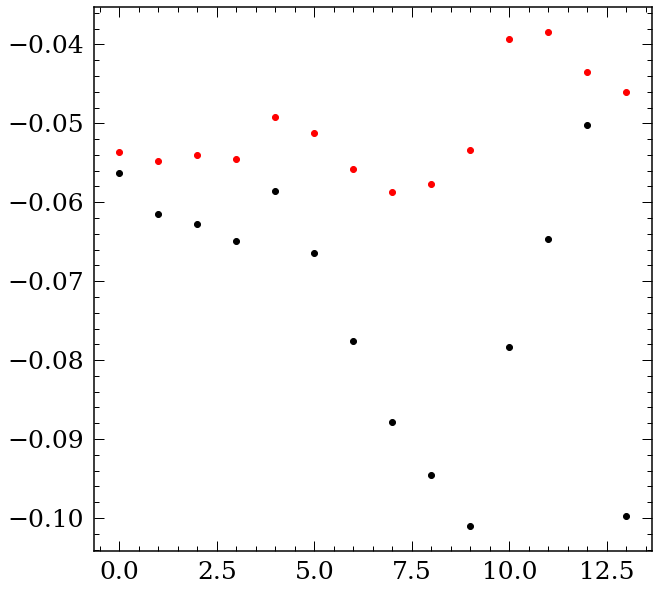

In [1187]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, m):
    return m*x+b

agebin = np.linspace(0,14,15)
for i in range(len(agebin)-1):
    m = (data['age']>agebin[i])&(data['age']<agebin[i+1])
    data_s = data[m]
    p = fitpoints(data_s['R_bir'], data_s['feh'])
    b = p[0]
    popt, pcov = curve_fit(func, data_s['R'], data_s['feh'])
    
    print(p[1],popt[0])
    
    plt.plot(agebin[i], p[1], 'ko')
    plt.plot(agebin[i], popt[0], 'ro')

    #plt.plot(popt[0], p[1], 'ko')
    